## Segmentation.
In this task, you will need to solve the problem of semantic segmentation of the attributes of a person's face. You will work with [CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ) dataset. You are free to solve and implement required steps on your own. However, there are several constraints and advices:
- To speed up and simplify experiments, you can transform images to 512x512 resolution and use this [train-test split](https://drive.google.com/file/d/1vO4mJ08FMdcom2-sNs4WHxPztIRYrFYI/view?usp=share_link), that has smaller number of images.
- (20 pts) Implement needed train-test pipeline (dataset, model, train and test loops), train and test the model. 
  - (10 pts) Bonus: your own model, not taken from libraries and not a Unet.
- (5 pts) Report IoU and Dice-scores of each class on the test set.
- (5 pts) Try to add augmentations (helpful [link1](https://albumentations.ai/) and [link2](https://kornia.github.io/)).
- (2 pts) Plot 4-6 examples of obtained results on the test set (show the best and the worst according to the loss/metrics).
- (3 pts) Explain why you solved the problem this way and not otherwise, provide description of experiments and their results. Analyze your metrics, are they suitable?
- (5 pts) Make additional function for inference that receives path to the image. Test your model on several photos not from the dataset (pick your own photo or any other from internet). Does your model work well on the new data?
- Do not use already pretrained on CelebAMask-HQ models.
- **Bonus**: 
  - **+10 points** for top-1 result
  - **+8 points** for 2-3 places
  - **+5 points** for 4-8 places 
according to reported mean Dice score on the provided test split.

In [ ]:
import gdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import torch
import torch.nn as nn
import torchvision

from tqdm import trange
from tqdm import tqdm

from shutil import copyfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.nn import functional as F
import albumentations as A
from torchvision.transforms import ToTensor

import os


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
sharing_link = "https://drive.google.com/file/d/1FUXnb_5Njv4kPYR1f4Ws5U037Wf8kWqS/view?usp=share_link"
gdown.download(url=sharing_link, output="./data.zip", quiet=False, fuzzy=True)
!unzip ./data.zip

Downloading...
From: https://drive.google.com/uc?id=1FUXnb_5Njv4kPYR1f4Ws5U037Wf8kWqS
To: /content/data.zip
100%|██████████| 3.15G/3.15G [00:33<00:00, 93.5MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_neck.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_nose.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_r_brow.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_r_eye.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_skin.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_u_lip.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_hair.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_brow.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_eye.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_lip.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_mouth.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_neck.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_nose.png  
  inflating: CelebAMask-HQ/Cel

In [ ]:
torch.random.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_path = './CelebAMask-HQ'
device

device(type='cpu')

In [ ]:
!ls CelebAMask-HQ/

CelebA-HQ-img			  CelebAMask-HQ-mask-anno
CelebA-HQ-to-CelebA-mapping.txt   CelebAMask-HQ-pose-anno.txt
CelebAMask-HQ-attribute-anno.txt  README.txt


In [ ]:
mapping_df = pd.read_fwf(os.path.join(data_path,'CelebA-HQ-to-CelebA-mapping.txt'))
mapping_df = mapping_df.drop(['idx'],axis=1)


In [ ]:
label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']

folder_base = 'CelebAMask-HQ-mask-anno'
folder_save = 'CelebAMask-HQ-label'


img_num = 30000

if not os.path.exists(os.path.join(data_path,folder_save)):
    os.makedirs(os.path.join(data_path,folder_save))

for k in trange(img_num):
    folder_num = k // 2000
    im_base = np.zeros((512, 512))
    for idx, label in enumerate(label_list):
        filename = os.path.join(data_path,folder_base, str(folder_num), str(k).rjust(5, '0') + '_' + label + '.png')
        if (os.path.exists(filename)):

            im = cv2.imread(filename)
            im = im[:, :, 0]
            im_base[im != 0] = (idx + 1)

    filename_save = os.path.join(data_path,folder_save, str(k) + '.png')
    cv2.imwrite(filename_save, im_base)

100%|██████████| 30000/30000 [20:30<00:00, 24.37it/s]


In [ ]:
#### source data path
s_label = 'CelebAMask-HQ-label'
s_img = 'CelebA-HQ-img'
#### destination training data path
d_train_label = 'train_label'
d_train_img = 'train_img'
#### destination testing data path
d_test_label = 'test_label'
d_test_img = 'test_img'
#### val data path
d_val_label = 'val_label'
d_val_img = 'val_img'


list_dir = [d_train_label, d_train_img, d_test_label, d_test_img, d_val_label, d_val_img]

for directory in list_dir:
    if not os.path.exists(os.path.join(data_path,directory)):
            os.makedirs(os.path.join(data_path,directory))
            
#### calculate data counts in destination folder
train_count = 0
test_count = 0
val_count = 0


for idx, x in enumerate(mapping_df.iloc[:, 0]):
    if x >= 162771 and x < 182638:
        copyfile(os.path.join(data_path,s_label, str(idx)+'.png'), os.path.join(data_path,d_val_label, str(val_count)+'.png'))
        copyfile(os.path.join(data_path,s_img, str(idx)+'.jpg'), os.path.join(data_path,d_val_img, str(val_count)+'.jpg'))        
        val_count += 1

    elif x >= 182638:
        copyfile(os.path.join(data_path, s_label, str(idx)+'.png'), os.path.join(data_path, d_test_label, str(test_count)+'.png'))
        copyfile(os.path.join(data_path, s_img, str(idx)+'.jpg'), os.path.join(data_path, d_test_img, str(test_count)+'.jpg'))
        test_count += 1 
    else:
        copyfile(os.path.join(data_path, s_label, str(idx)+'.png'), os.path.join(data_path, d_train_label, str(train_count)+'.png'))
        copyfile(os.path.join(data_path, s_img, str(idx)+'.jpg'), os.path.join(data_path, d_train_img, str(train_count)+'.jpg'))
        train_count += 1  

print ( 'total amount of pictures',train_count + test_count + val_count)



total amount of pictures 30000


In [ ]:
!ls CelebAMask-HQ

CelebA-HQ-img			  CelebAMask-HQ-pose-anno.txt  train_label
CelebA-HQ-to-CelebA-mapping.txt   README.txt		       val_img
CelebAMask-HQ-attribute-anno.txt  test_img		       val_label
CelebAMask-HQ-label		  test_label
CelebAMask-HQ-mask-anno		  train_img


In [ ]:
! cp -R CelebAMask-HQ/train_label "drive/My Drive/Colab Notebooks/DL'23/HW2/CelebAMask-HQ/train_label"

In [ ]:
 
! cp -R CelebAMask-HQ/train_img "drive/My Drive/Colab Notebooks/DL'23/HW2/CelebAMask-HQ/train_img"
! cp -R CelebAMask-HQ/test_label "drive/My Drive/Colab Notebooks/DL'23/HW2/CelebAMask-HQ/test_label"
! cp -R CelebAMask-HQ/test_img "drive/My Drive/Colab Notebooks/DL'23/HW2/CelebAMask-HQ/test_img"
! cp -R CelebAMask-HQ/val_label "drive/My Drive/Colab Notebooks/DL'23/HW2/CelebAMask-HQ/val_label"
! cp -R CelebAMask-HQ/val_img "drive/My Drive/Colab Notebooks/DL'23/HW2/CelebAMask-HQ/val_img"

In [ ]:
class CelebAMaskHQDataset(Dataset):
    def __init__(self, img_path, label_path, transform_img, n_class):
        self.img_path = img_path
        self.label_path = label_path
        self.transform_img = transform_img
        self.dataset = []
        self.n_class = n_class
        self.preprocess()
        self.to_tensor = ToTensor()

    def preprocess(self):
        
        for i in range(len([name for name in os.listdir(self.img_path) if os.path.isfile(os.path.join(self.img_path, name))])):
            img_path = os.path.join(self.img_path, str(i)+'.jpg')
            label_path = os.path.join(self.label_path, str(i)+'.png')
            #print (img_path, label_path) 
            self.dataset.append([img_path, label_path])
            
        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        
        img_path, label_path = self.dataset[index]
        image = Image.open(img_path)
        label = cv2.imread(label_path) [:,:,1]
        label = torch.Tensor(label)

        transformed = self.transform_img(image=np.asarray(image), mask=np.asarray(label))
       
        
        image = transformed['image']
        mask = transformed['mask']
        
        
        image = self.to_tensor(image.copy())
        
        mask = self.to_tensor(mask.copy()).squeeze()
        mask = F.one_hot(mask.long(), self.n_class + 0).permute(2,0,1)
        if mask.shape[0] < self.n_class:
            n_zeros = self.n_class - mask.shape[0]
            mask = torch.cat((mask, torch.zeros((n_zeros, mask.shape[1],mask.shape[2]))),dim=0)
        
        return image, mask

    def __len__(self):
        """Return the number of images."""
        return len(self.dataset)

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/DL'23/HW2/CelebAMask-HQ"

In [ ]:
batch_size = 2

image_size = (512,512)
num_workers = 3

label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']
n_classes = len(label_list) + 1
train_transform_img = A.Compose([
    A.Resize(*image_size),
    A.Rotate(),
    A.ColorJitter(),
    A.VerticalFlip(),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
])
   
train_img_path = os.path.join(data_path,'train_img')
train_label_path = os.path.join(data_path,'train_label')
train_set = CelebAMaskHQDataset(train_img_path, train_label_path, train_transform_img, n_class=n_classes)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=num_workers)


test_transform_img = A.Compose([
    A.Resize(*image_size)
])

   
test_img_path = os.path.join(data_path,'test_img')
test_label_path = os.path.join(data_path,'test_label')
test_set = CelebAMaskHQDataset(test_img_path, test_label_path, test_transform_img,n_class=n_classes)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=num_workers)


Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Finished preprocessing the CelebA dataset...


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/DL'23/HW2/CelebAMask-HQ"

models	test_img  test_label  train_img  train_label  val_img  val_label


In [ ]:
def iou_dice_score(preds,target_mask,n_classes,delta = 1e-10):
    preds = torch.argmax(preds, dim=1)
    preds_mask = F.one_hot(preds, n_classes).permute(0,3,1,2)
    log_and = torch.logical_and(preds_mask, target_mask)
    log_or = torch.logical_or(preds_mask, target_mask)
    overlap = torch.sum(log_and, dim =(2,3))
    union = torch.sum(log_or, dim =(2,3))
    sum = torch.sum(preds_mask, dim =(2,3)) + torch.sum(target_mask, dim =(0,2,3))
    
    iou = overlap/(union + delta)
    dice = 2*overlap/(sum + delta)
    return iou, dice
    

In [ ]:
class Encoder_Block(torch.nn.Module):
    def __init__(self, inp_channels, out_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.pooling = torch.nn.MaxPool2d(2)
    def forward(self,x):
        int_out = self.model(x)
        return self.pooling(int_out), int_out

class Decoder_Block(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
    def forward(self,x,enc_x):
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)

In [ ]:
class Unet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=64):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block(hidden_size*16,hidden_size*8),
            Decoder_Block(hidden_size*8,hidden_size*4),
            Decoder_Block(hidden_size*4,hidden_size*2),
            Decoder_Block(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same")
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)
    

In [ ]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    
    for model_input, target in tqdm(loader):
        model_input = model_input.to(device)
        target = target.to(device)
        model_output = clf(model_input)
        loss = criterion(model_output,target.to(torch.float))

        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss


def epoch_test(loader, clf, criterion, n_classes):
    clf.eval()

    iou_all = None
    dice_all = None


    for model_input, target in tqdm(loader):
        model_input = model_input.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            
            model_output = clf(model_input)
            
            loss = criterion(model_output,target.to(torch.float))
            iou, dice = iou_dice_score(model_output,target,n_classes)
            
            if iou_all is None:
                iou_all = iou
                dice_all = dice
            else:
                iou_all = torch.cat((iou_all, iou),dim=0)
                dice_all = torch.cat((dice_all, dice),dim=0)
                
    iou_m = iou_all.mean(dim=0)
    dice_m = dice_all.mean(dim=0)

    return iou_m, dice_m

def train(train_loader, test_loader, clf,n_classes, criterion, opt, n_epochs=8):

    for epoch in range(n_epochs):

        train_loss = epoch_train(train_loader, clf, criterion, opt)
        iou_m, dice_m = epoch_test(test_loader, clf, criterion, n_classes)
        
        iou = dict(zip(['zero'] + label_list,iou_m.tolist()))
        dice = dict(zip(['zero'] + label_list,dice_m.tolist()))
        

        print(f'[Epoch {epoch + 1}]')
        
        path_model = os.path.join(data_path, f'models/unet_{epoch + 1}ep.pth')
        torch.save(clf, path_model)
        
        print(f'Test IoU scores:')
        for key, value in iou.items():
            print (key, ": {:.3f}".format(value))
        print('Test Dice scores:')
        for key, value in dice.items():
            print (key, ": {:.3f}".format(value))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = Unet(3,19).to(device)
optimizer = torch.optim.Adam(unet.parameters(),lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
#train unet
train(train_loader, test_loader,unet, n_classes, criterion,optimizer,n_epochs=2)

100%|███████████████████████████████████████| 1412/1412 [03:02<00:00,  7.76it/s]


[Epoch 1]
Test IoU scores:
background : 0.764
skin : 0.825
nose : 0.705
eye_g : 0.001
l_eye : 0.031
r_eye : 0.304
l_brow : 0.049
r_brow : 0.268
l_ear : 0.175
r_ear : 0.007
mouth : 0.348
u_lip : 0.320
l_lip : 0.489
hair : 0.731
hat : 0.000
ear_r : 0.042
neck_l : 0.000
neck : 0.546
cloth : 0.153
Test Dice scores:
background : 0.564
skin : 0.606
nose : 0.533
eye_g : 0.001
l_eye : 0.032
r_eye : 0.313
l_brow : 0.050
r_brow : 0.283
l_ear : 0.198
r_ear : 0.010
mouth : 0.331
u_lip : 0.285
l_lip : 0.433
hair : 0.552
hat : 0.000
ear_r : 0.057
neck_l : 0.000
neck : 0.444
cloth : 0.162


100%|███████████████████████████████████████| 1412/1412 [03:05<00:00,  7.61it/s]


[Epoch 2]
Test IoU scores:
background : 0.814
skin : 0.872
nose : 0.822
eye_g : 0.029
l_eye : 0.027
r_eye : 0.372
l_brow : 0.264
r_brow : 0.182
l_ear : 0.211
r_ear : 0.005
mouth : 0.406
u_lip : 0.674
l_lip : 0.691
hair : 0.780
hat : 0.001
ear_r : 0.040
neck_l : 0.000
neck : 0.648
cloth : 0.202
Test Dice scores:
background : 0.591
skin : 0.622
nose : 0.597
eye_g : 0.037
l_eye : 0.026
r_eye : 0.382
l_brow : 0.264
r_brow : 0.189
l_ear : 0.227
r_ear : 0.007
mouth : 0.369
u_lip : 0.531
l_lip : 0.523
hair : 0.571
hat : 0.002
ear_r : 0.053
neck_l : 0.000
neck : 0.495
cloth : 0.202


In [ ]:

path_model = "/content/drive/MyDrive/Colab Notebooks/DL'23/HW2/CelebAMask-HQ/models/unet_2ep.pth"
un = torch.load(path_model, map_location=torch.device('cpu'))
un.to(device)
un.eval()

Unet(
  (Encoder): ModuleList(
    (0): Encoder_Block(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Encoder_Block(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [ ]:
def plot_model_output(loader,ind,model,title=None):
    n = 3
    dataset = loader.dataset
    fig, ax = plt.subplots(1,n,figsize=(n*3,n))
    ax[0].axis('off')
    ax[1].axis('off')

    img = dataset[ind][0][:,:,:]
    mask = dataset[ind][1][:,:,:]
    out = (model(img[None,:].to(device)).to('cpu')).view(n_classes,*image_size)
    
    iou, dice = iou_dice_score(out[None,:],mask[None,:],n_classes)
    
    iou_mean = iou.mean()
    dice_mean = dice.mean()
    
    ax[0].set_title(f'original image ')
    ax[1].set_title(f'label')
    ax[2].set_title(f'output, iou mean: {iou_mean:.4f}, dice mean: {dice_mean:.4f}')
    ax[0].imshow(img.permute(1,2,0))
    
    mask = torch.argmax(mask, dim=0)[None,:,:]
    ax[1].imshow(mask.permute(1,2,0))
    
    preds = out.detach()
    preds = torch.argmax(preds, dim=0)[None,:,:]
    
    ax[2].imshow(preds.permute(1,2,0))
    fig.suptitle(title)
    

In [ ]:
def plot_results(loader,index,model):
    n = 3
    dataset = loader.dataset
    fig, ax = plt.subplots(1,n,figsize=(n*3,n))
    img = dataset[index][0]
    mask = dataset[index][1]
    out = (model(img[None,:].to(device)).to('cpu')).view(19,512,512)
    
    iou, dice = iou_dice_score(out[None,:],mask[None,:],n_classes)
    
    iou_mean = iou.mean()
    dice_mean = dice.mean()
    
    ax[0].set_title(f'original image ')
    ax[1].set_title(f'label')
    ax[2].set_title('output')
    print(f'iou mean: {iou_mean:.4f}, dice mean: {dice_mean:.4f}')
    ax[0].imshow(img.permute(1,2,0))
    
    mask = torch.argmax(mask, dim=0)[None,:,:]
    ax[1].imshow(mask.permute(1,2,0))
    
    preds = torch.argmax(out.detach(), dim=0)[None,:,:]
    
    ax[2].imshow(preds.permute(1,2,0))


iou mean: 0.3823, dice mean: 0.4437


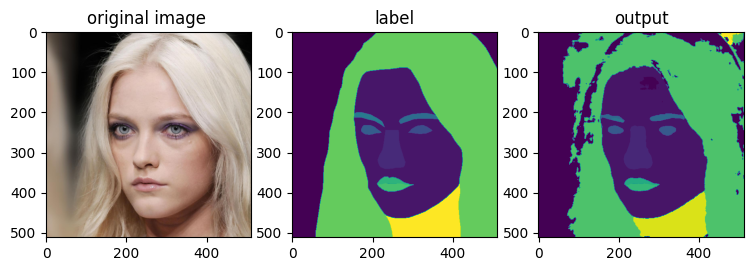

In [ ]:
plot_results(test_loader, 11, un)

iou mean: 0.3334, dice mean: 0.4036


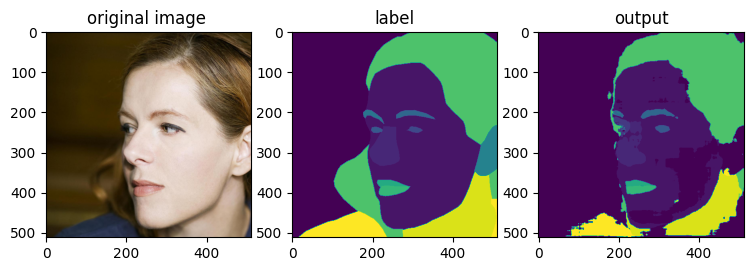

In [ ]:
plot_results(test_loader, 101, un)

iou mean: 0.4235, dice mean: 0.4934


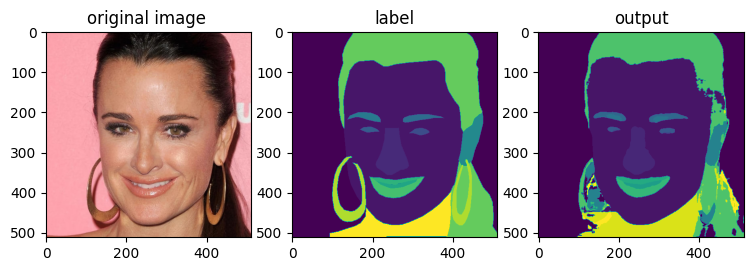

In [ ]:
plot_results(test_loader, 1010, un)

iou mean: 0.3094, dice mean: 0.3597


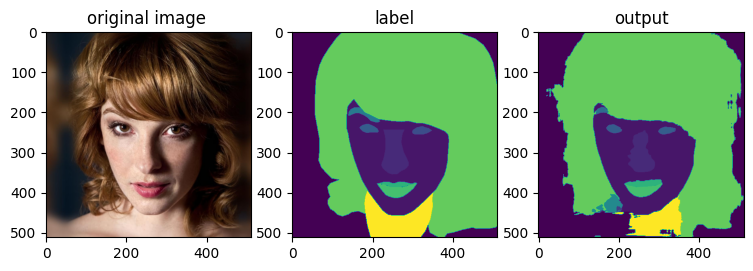

In [ ]:
plot_results(test_loader, 1100, un)

iou mean: 0.3363, dice mean: 0.4036


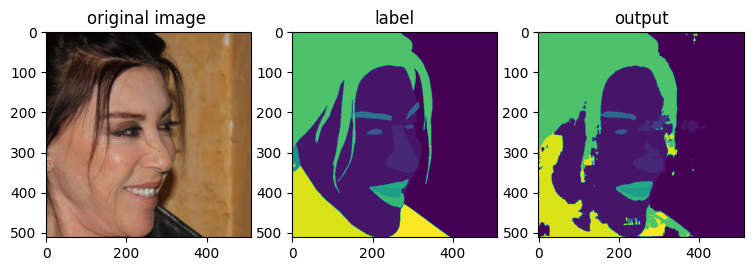

In [ ]:
plot_results(test_loader, 1000, un)

### Explain why you solved the problem this way and not otherwise, provide description of experiments and their results. Analyze your metrics, are they suitable?

I trained Unet model, but it took so many time for each epoch... This is why I trained it only for 2 epochs, results could be better if I increase number of epochs. Also it could be possible to obtain better result with pretrained model.
I have used mean IoU for all classes.